In [1]:
# required packages here
library("ggplot2")
# library(randomcoloR)

Warning message:
"package 'ggplot2' was built under R version 4.1.3"


In [2]:
data <- read.csv("hotel_bookings.csv")
dim(data)

[1] 119390     32

In [243]:
head(data)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,...,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>
1,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01
3,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NULL,NULL,0,Transient,75,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304,NULL,0,Transient,75,0,0,Check-Out,2015-07-02
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,2015-07-03


In [244]:
str(data)

'data.frame':	119390 obs. of  32 variables:
 $ hotel                         : chr  "Resort Hotel" "Resort Hotel" "Resort Hotel" "Resort Hotel" ...
 $ is_canceled                   : int  0 0 0 0 0 0 0 0 1 1 ...
 $ lead_time                     : int  342 737 7 13 14 14 0 9 85 75 ...
 $ arrival_date_year             : int  2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 ...
 $ arrival_date_month            : chr  "July" "July" "July" "July" ...
 $ arrival_date_week_number      : int  27 27 27 27 27 27 27 27 27 27 ...
 $ arrival_date_day_of_month     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ stays_in_weekend_nights       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ stays_in_week_nights          : int  0 0 1 1 2 2 2 2 3 3 ...
 $ adults                        : int  2 2 1 1 2 2 2 2 2 2 ...
 $ children                      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ babies                        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ meal                          : chr  "BB" "BB" "BB" "BB" ...
 $ country                 

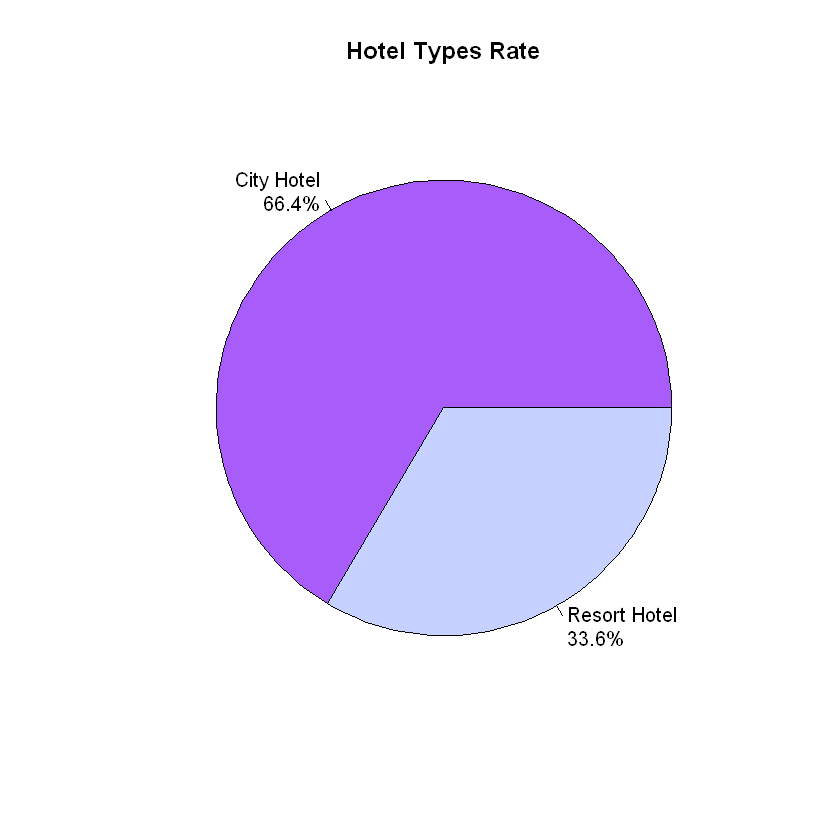

In [245]:
purple <- "#633ebb"
light_purple <- "#A85CF9"
red <- "#f13c59"
light_blue <- "#c6d1ff"
blue <- "#40DFEF"

beige <- "#fec57e"
colors <- c(light_purple, light_blue)

hotel <- table(data$hotel)
hotel_types <- c("City Hotel", "Resort Hotel")

pie_percent<- paste(hotel_types, round(100*hotel/sum(hotel), 1), sep="\n") 
pie_percent<- paste(pie_percent, "%", sep="") 
pie(hotel, main = "Hotel Types Rate", labels=pie_percent, col = colors)



# Data Preprocessing

In [246]:
data$arrival_date_month <- factor(data$arrival_date_month)   
levels(data$arrival_date_month) <- list(Jan = "January",
                                       Feb = "February",
                                       Mar = "March",
                                       Apr = "April",
                                       May = "May",
                                       Jun = "June",
                                       Jul = "July",
                                       Aug = "August",
                                       Sep = "September",
                                       Oct = "October",
                                       Nov = "November",
                                       Dec = "December")

levels(data$arrival_date_month)
table(data$arrival_date_month)

[1] "Jan" "Feb" "Mar" "Apr" "May" "Jun" "Jul" "Aug" "Sep" "Oct" "Nov" "Dec"


  Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec 
 5929  8068  9794 11089 11791 10939 12661 13877 10508 11160  6794  6780 

In [247]:
colSums(is.na(data) | data == "NULL")

hotel                    is_canceled 
                             0                              0 
                     lead_time              arrival_date_year 
                             0                              0 
            arrival_date_month       arrival_date_week_number 
                             0                              0 
     arrival_date_day_of_month        stays_in_weekend_nights 
                             0                              0 
          stays_in_week_nights                         adults 
                             0                              0 
                      children                         babies 
                             4                              0 
                          meal                        country 
                             0                            488 
                market_segment           distribution_channel 
                             0                              0 
             is_repeated_guest         previous_cancellations 
                             0                              0 
previous_bookings_not_canceled             reserved_room_type 
                             0                              0 
            assigned_room_type                booking_changes 
                             0                              0 
                  deposit_type                          agent 
                             0                          16340 
                       company           days_in_waiting_list 
                        112593                              0 
                 customer_type                            adr 
                             0                              0 
   required_car_parking_spaces      total_of_special_requests 
                             0                              0 
            reservation_status        reservation_status_date 
                             0                              0

In [248]:
data$children[is.na(data$children)] = 0

levels(data$country) <- c(levels(data$country), "UNKNOWN") 
data$country[data$country == "NULL"] <- "UNKNOWN"
data$country = factor(data$country)

levels(data$agent) <- c(levels(data$agent), '0')
data$agent[data$agent == "NULL"] <- '0'
data$agent = factor(data$agent)

levels(data$company) <- c(levels(data$company), '0')
data$company[data$company == "NULL"] <- '0'
data$company = factor(data$company)

In [249]:
colSums(is.na(data) | data == "NULL")

hotel                    is_canceled 
                             0                              0 
                     lead_time              arrival_date_year 
                             0                              0 
            arrival_date_month       arrival_date_week_number 
                             0                              0 
     arrival_date_day_of_month        stays_in_weekend_nights 
                             0                              0 
          stays_in_week_nights                         adults 
                             0                              0 
                      children                         babies 
                             0                              0 
                          meal                        country 
                             0                              0 
                market_segment           distribution_channel 
                             0                              0 
             is_repeated_guest         previous_cancellations 
                             0                              0 
previous_bookings_not_canceled             reserved_room_type 
                             0                              0 
            assigned_room_type                booking_changes 
                             0                              0 
                  deposit_type                          agent 
                             0                              0 
                       company           days_in_waiting_list 
                             0                              0 
                 customer_type                            adr 
                             0                              0 
   required_car_parking_spaces      total_of_special_requests 
                             0                              0 
            reservation_status        reservation_status_date 
                             0                              0

In [250]:
threshold = 400
outliers = data[data$lead_time > threshold, ]

percentage = nrow(outliers)/nrow(data) * 100
sprintf("Percentage data that has lead time greater than %d days is %.2f%%", threshold, percentage)

data = data[data$lead_time <= threshold, ]

[1] "Percentage data that has lead time greater than 400 days is 1.77%"

In [251]:
data = data[data$stays_in_weekend_nights + data$stays_in_week_nights > 0,]

In [252]:
data = data[data$adults + data$children + data$babies > 0,]

In [253]:
filtered = !(data$is_repeated_guest==1 & (data$previous_cancellations + data$previous_bookings_not_canceled == 0))
data = data[filtered,]

In [254]:
dim(data)

[1] 116141     32

# Data Visualization

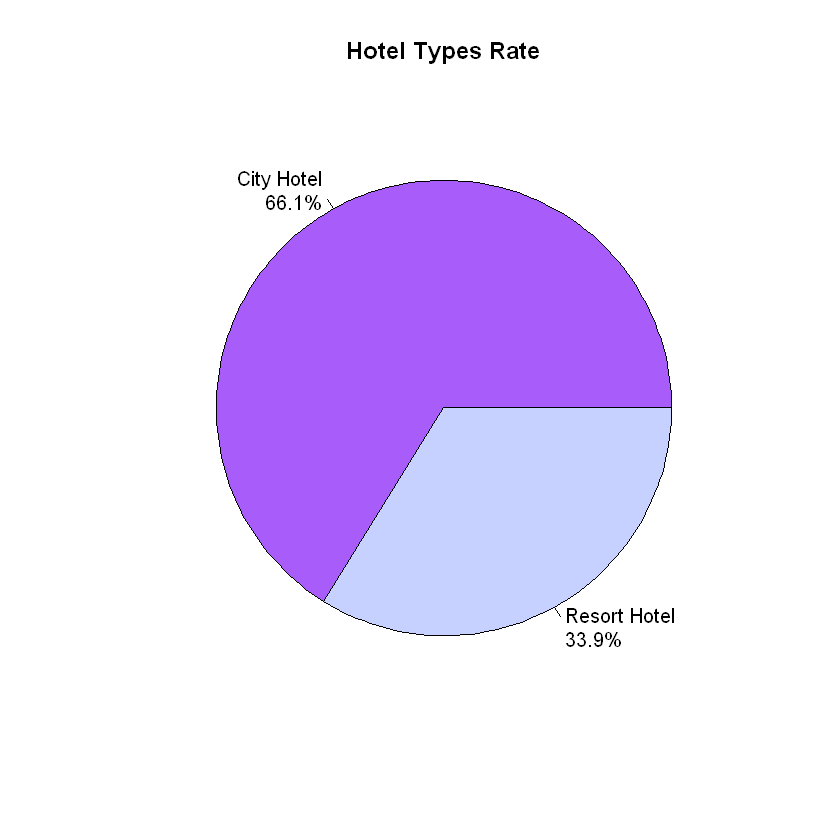

In [255]:
hotel <- table(data$hotel)
hotel_types <- c("City Hotel", "Resort Hotel")

pie_percent<- paste(hotel_types, round(100*hotel/sum(hotel), 1), sep="\n") 
pie_percent<- paste(pie_percent, "%", sep="") 
pie(hotel, main = "Hotel Types Rate", labels=pie_percent, col = colors)

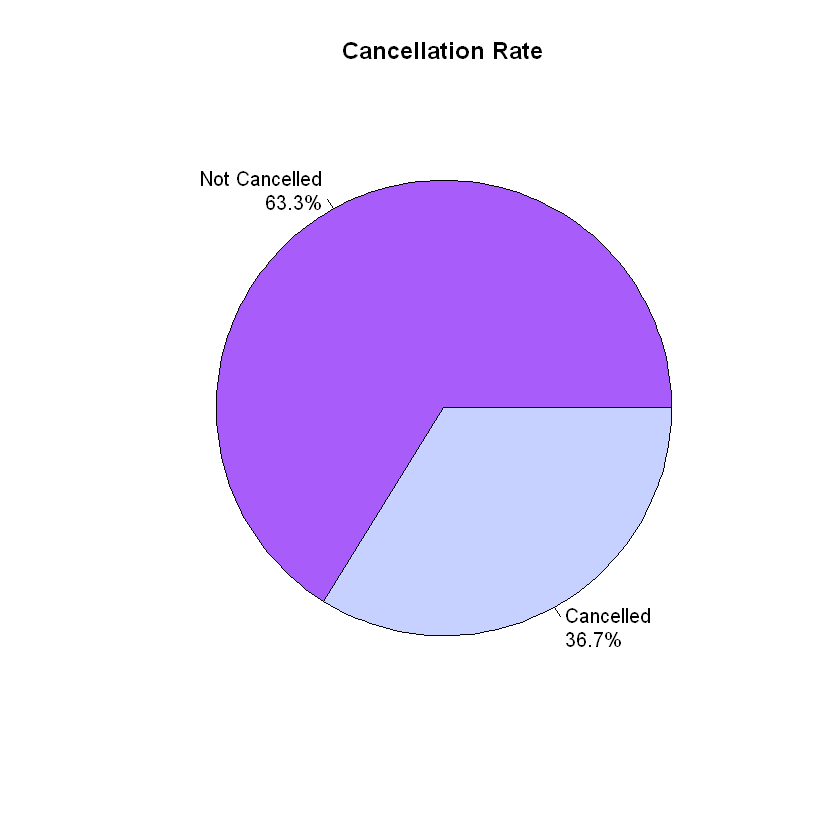

In [256]:
cancel <- table(data$is_canceled)
cancel_label <- c("Not Cancelled", "Cancelled")

pie_percent<- paste(cancel_label, round(100*cancel/sum(cancel), 1), sep="\n") 
pie_percent<- paste(pie_percent, "%", sep="") 
pie(hotel, main = "Cancellation Rate", labels=pie_percent, col = colors)

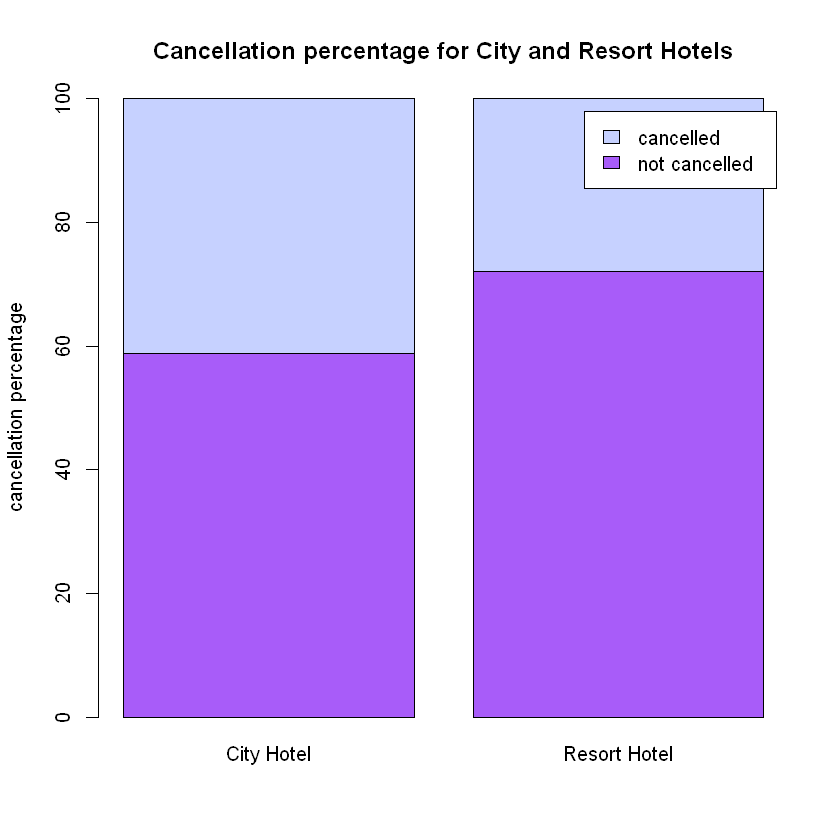

In [257]:
labels <- c("not cancelled", "cancelled")

hotel_cancel <- t(prop.table(table(data$hotel, data$is_canceled), margin = 1)*100)

barplot(hotel_cancel, main = "Cancellation percentage for City and Resort Hotels", 
        , ylim= c(0,100), ylab = "cancellation percentage", legend.text = labels, col = colors)


  Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec 
 5758  7886  9607 11008 11418 10771 12158 13503 10132 10794  6594  6512 


 Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec 
3635 4847 6320 7435 8008 7764 7641 8669 7066 7304 4198 3933 

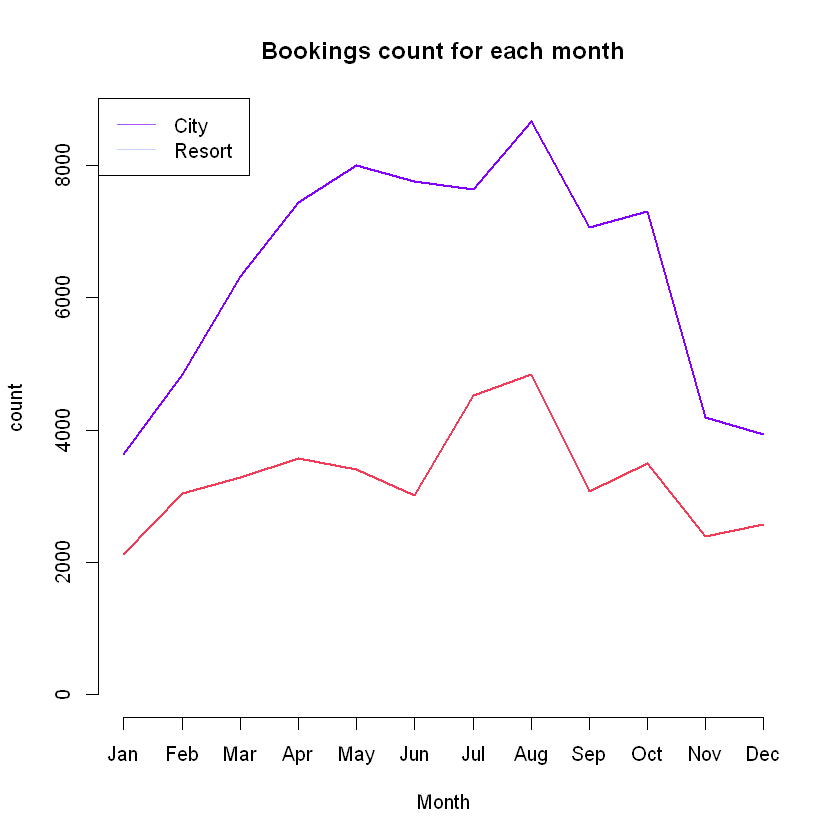

In [258]:
hotel_month <- table(data$hotel, data$arrival_date_month)
table(data$arrival_date_month)
city_month = table(data[data$hotel=='City Hotel',]$arrival_date_month)
resort_month = table(data[data$hotel=='Resort Hotel',]$arrival_date_month)
city_month
plot(city_month, xlab = "Month", ylab = "count", main = "Bookings count for each month", type="l", col = "#8300fd")
lines(resort_month, col = red, type="l")
legend("topleft", legend=c("City", "Resort"),
       col=colors, lty=c(1,1))

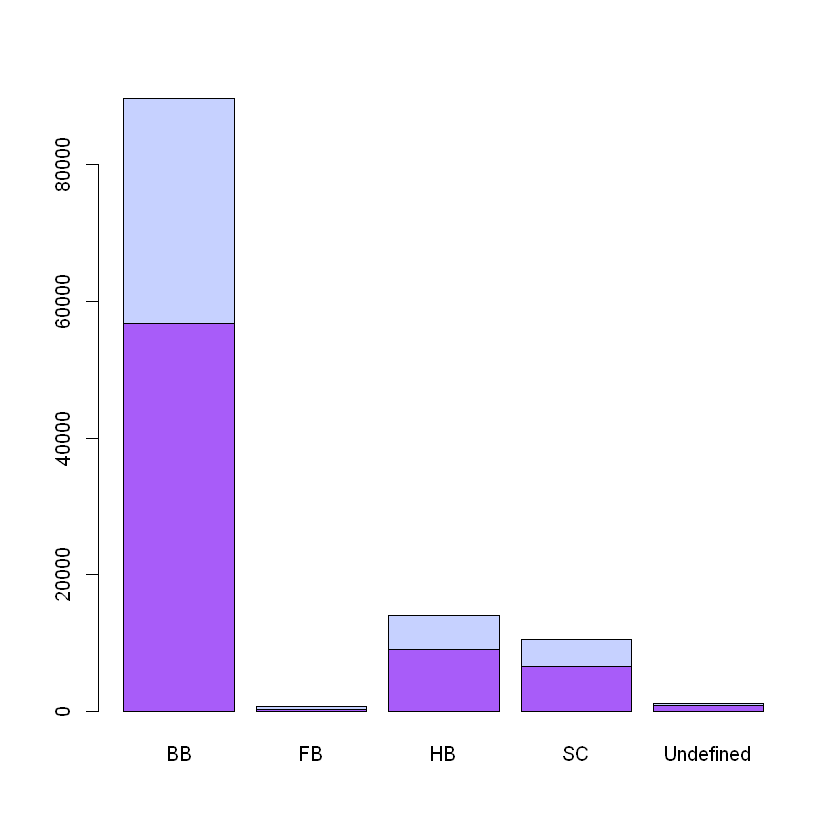

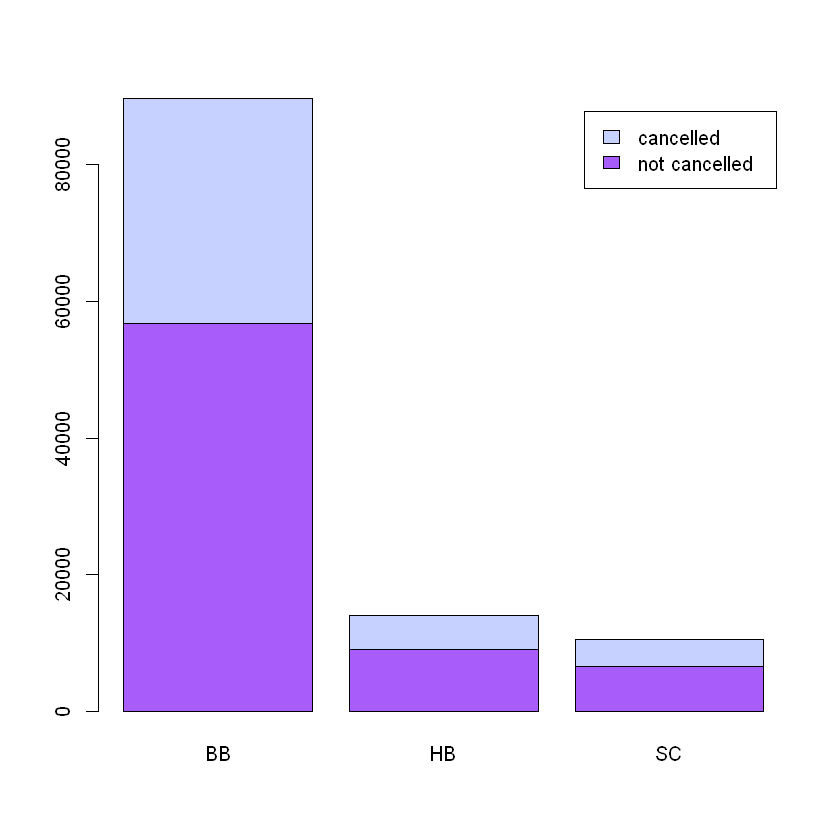

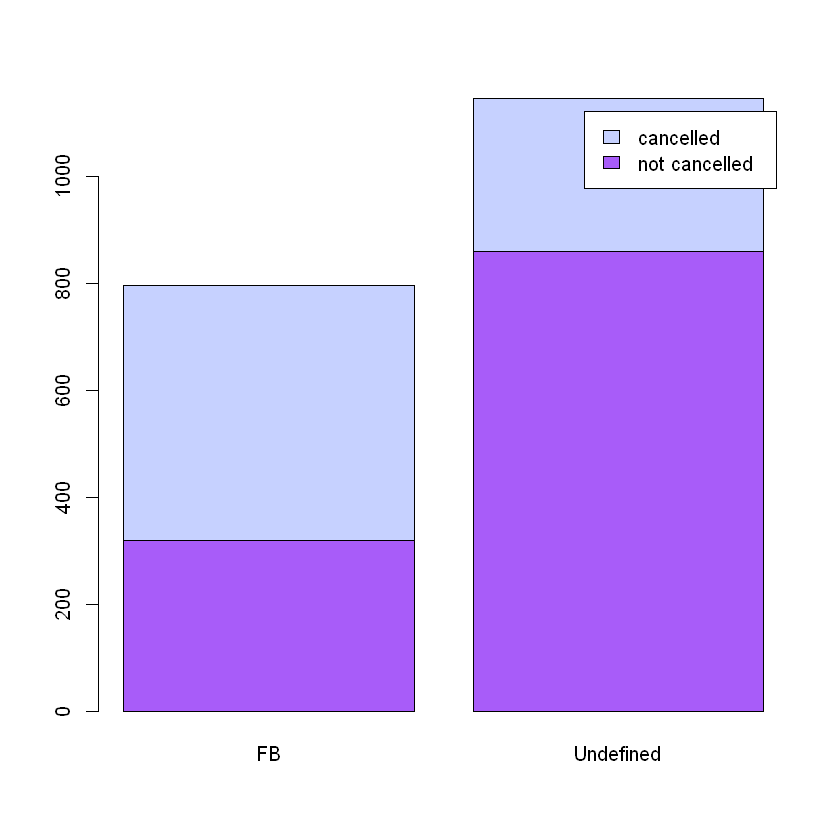

In [259]:
mean_cancel <- t(table(data$meal, data$is_canceled))

barplot(mean_cancel, col=colors)
barplot(mean_cancel[, -c(2, 5)], legend.text = labels, col=colors)
barplot(mean_cancel[, c(2, 5)], legend.text = labels, col=colors)

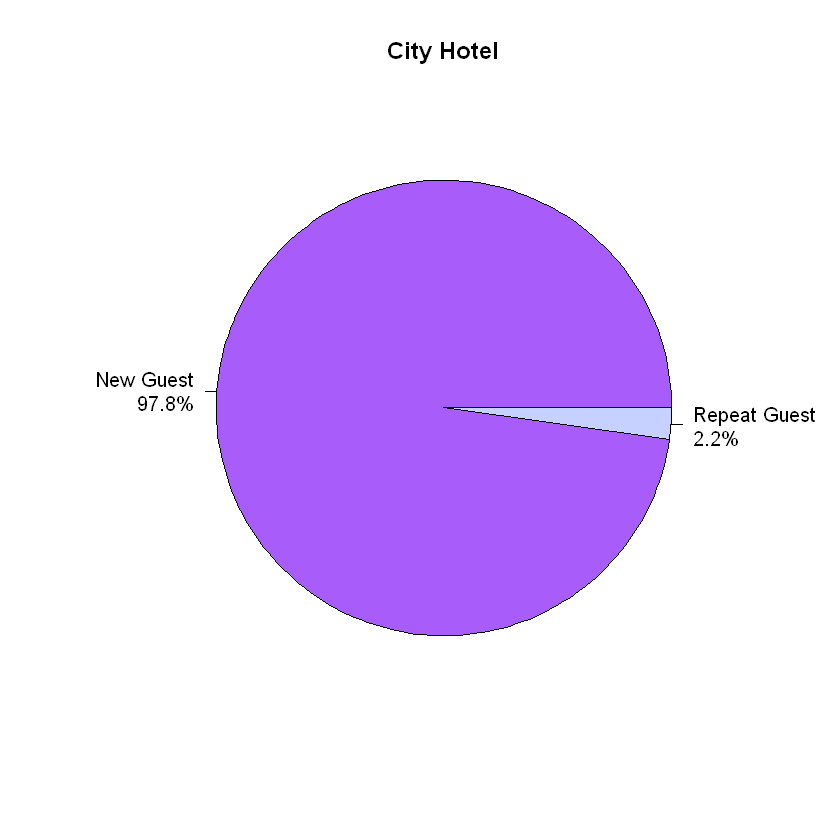

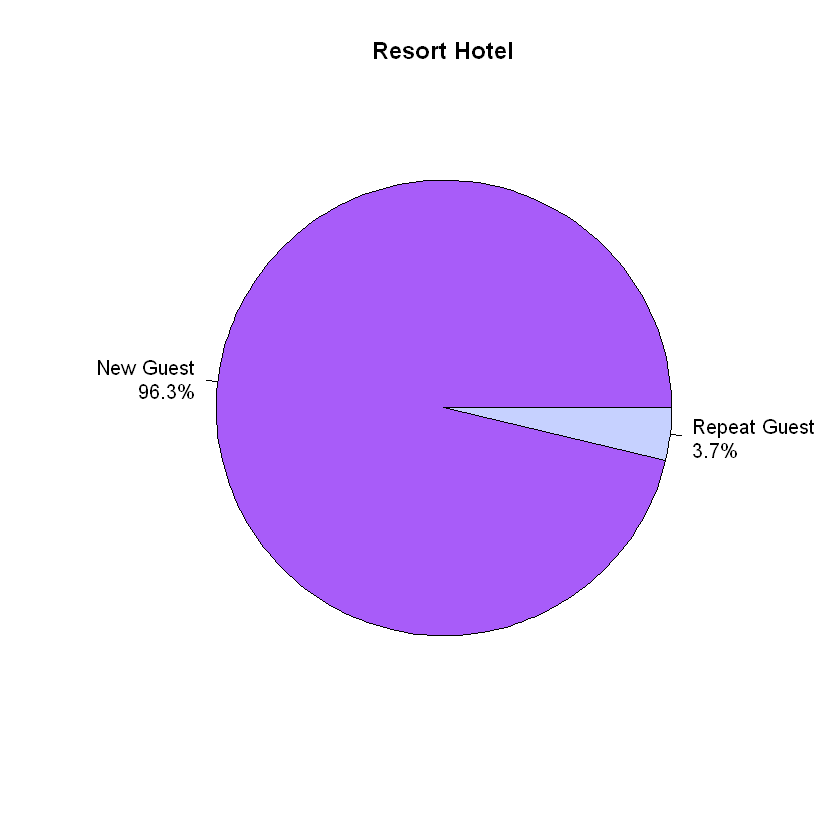

In [260]:
hotel_repeted <- table(data$is_repeated_guest, data$hotel)

repeat_city <- table(data[data$hotel == "City Hotel",]$is_repeated_guest)
repeat_resort <- table(data[data$hotel == "Resort Hotel",]$is_repeated_guest)

repeat_labels <- c("New Guest","Repeat Guest")

pie_percent<- paste(repeat_labels, round(100*repeat_city/sum(repeat_city), 1), sep="\n") 
pie_percent<- paste(pie_percent, "%", sep="") 
pie(repeat_city, labels=pie_percent, main = "City Hotel", col = colors)

pie_percent<- paste(repeat_labels, round(100*repeat_resort/sum(repeat_resort), 1), sep="\n") 
pie_percent<- paste(pie_percent, "%", sep="") 
pie(repeat_resort, labels=pie_percent, main = "Resort Hotel", col = colors)

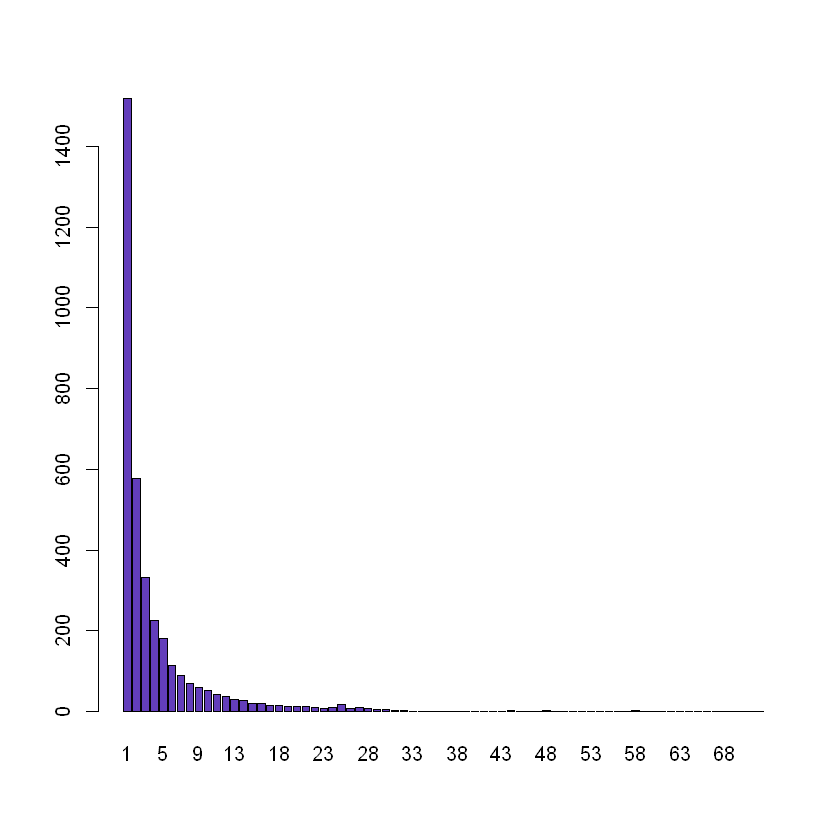

In [261]:
barplot(table(data$previous_bookings_not_canceled)[-1], col = c(purple))

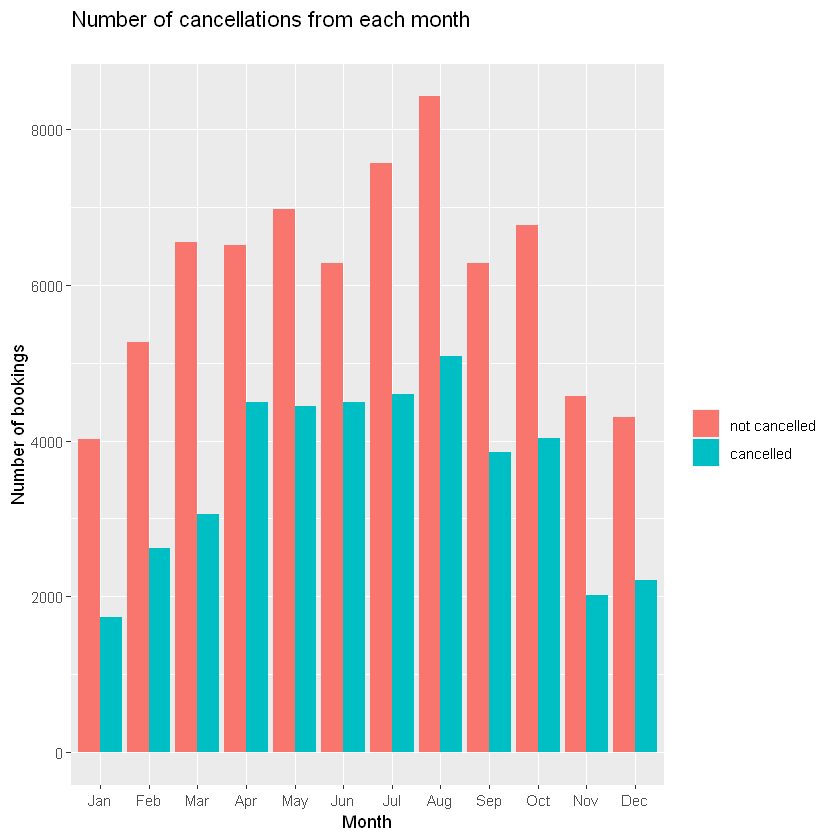

In [262]:
month_cancel <- table(data$is_canceled, data$arrival_date_month)

g <- ggplot(data, aes(x = arrival_date_month , fill = factor(is_canceled)))

g + geom_bar(position = position_dodge()) + 
labs(title = "Number of cancellations from each month\n", x = "Month", y = "Number of bookings")+
scale_fill_discrete(name="", labels=labels)


In [263]:
# color = grDevices::colors()[grep('gr(a|e)y', grDevices::colors(), invert = T)]
# cols <- sample(color, 178)

# country_city <- as.data.frame(country_city)

# ggplot(country_city, aes(x = "", y = sort(Freq), colour=Var1, fill= Var1))+
#  geom_col(color = "transparent", width = NULL) +
#   scale_fill_manual(values = sample(color, 178))+
#   coord_polar("y", start = 0) +
#   theme_void()

  AUT    CN   CHE   USA   NLD   BRA   BEL   IRL   ITA   DEU   ESP   FRA   GBR 
 1256  1267  1720  2066  2094  2212  2334  3363  3746  7016  8528 10350 11868 
  PRT OTHER 
46223 12098 


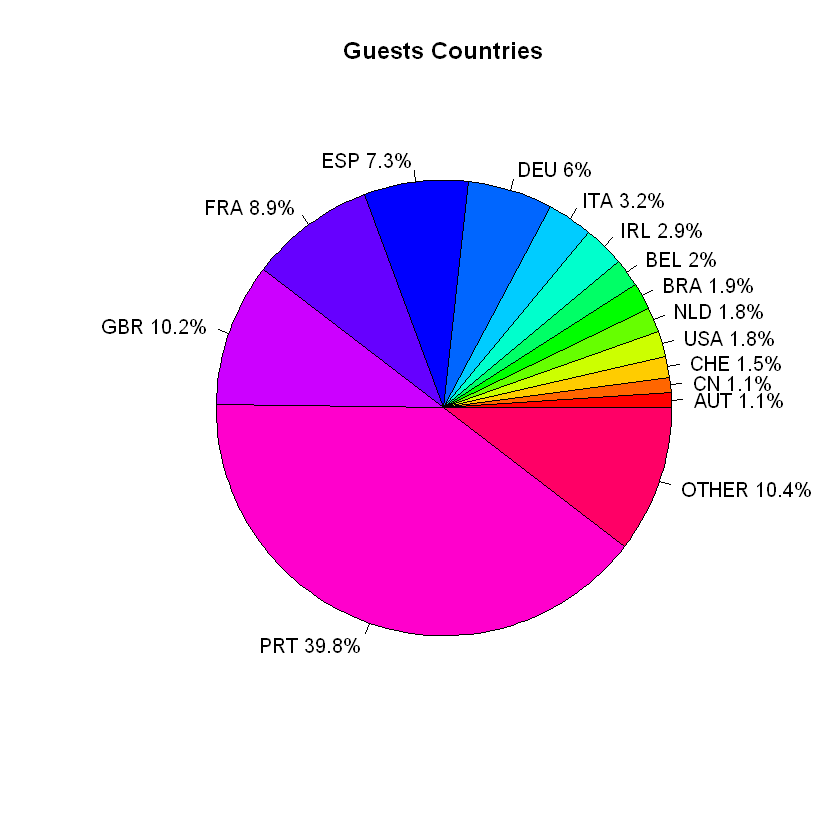

In [264]:
th = 1200
countries = table(data$country)
filtered_countries = countries[countries > th]
filtered_countries = sort(filtered_countries)
filtered_countries["OTHER"] = sum(countries[countries <= th])
print(filtered_countries)

labels = names(filtered_countries)

pie_percent<- paste(labels, round(100*filtered_countries/sum(filtered_countries), 1), sep=" ") 
pie_percent<- paste(pie_percent, "%", sep="")

pie(filtered_countries, main = "Guests Countries", labels=pie_percent, col = rainbow(length(filtered_countries)))

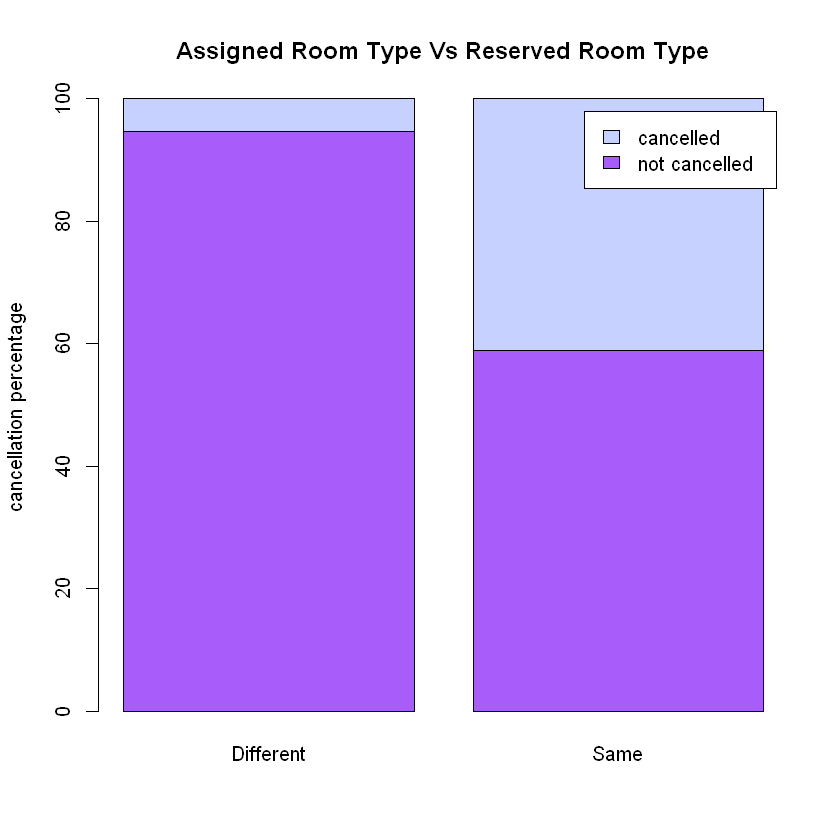

In [265]:
room_types = c("A", "B", "C", "D", "E", "F", "G", "H", "I", "K","L", "P")
f1 = factor(data$assigned_room_type, levels = room_types)
f2 = factor(data$reserved_room_type, levels = room_types)


labels <- c("not cancelled", "cancelled")

room_cancel <- prop.table(table(f1 == f2, data$is_canceled), margin=1)*100
rownames(room_cancel) = c("Different", "Same")
room_cancel <- t(room_cancel)

barplot(room_cancel, main = "Assigned Room Type Vs Reserved Room Type",ylab = "cancellation percentage",legend.text = labels, col = colors)

   
    No Deposit Non Refund Refundable
  0 71.3501305  0.6935545 77.5000000
  1 28.6498695 99.3064455 22.5000000

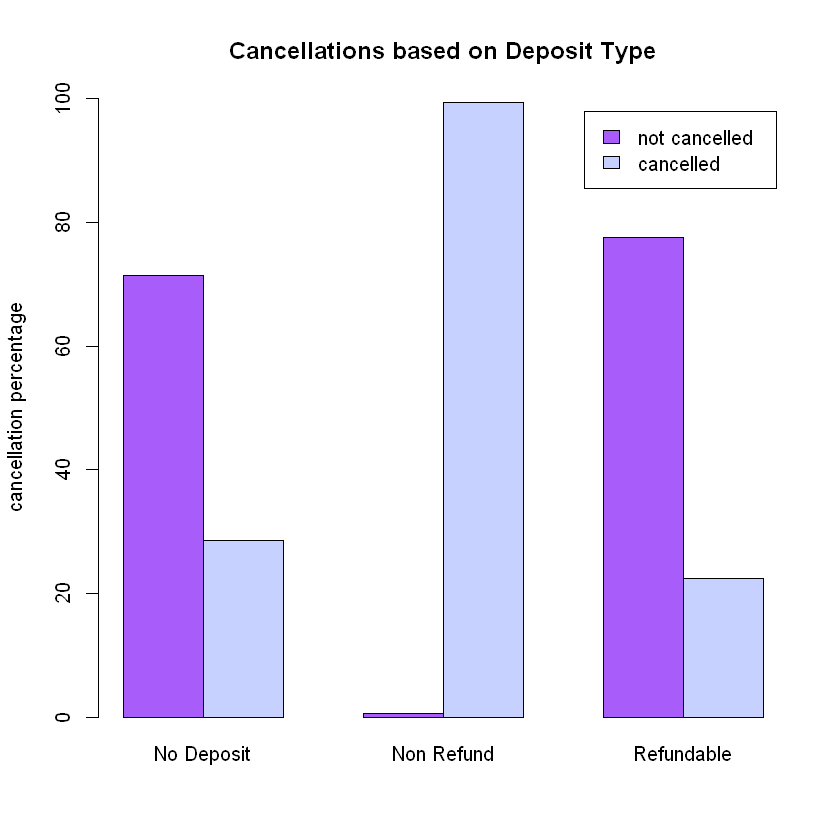

In [266]:
labels <- c("not cancelled", "cancelled")

deposit_cancellation <- t(prop.table(table(data$deposit_type, data$is_canceled), margin=1)*100)
deposit_cancellation

barplot(deposit_cancellation, beside = T, ylim = c(0,100),
        main = "Cancellations based on Deposit Type",ylab = "cancellation percentage",legend.text = labels, col = colors)


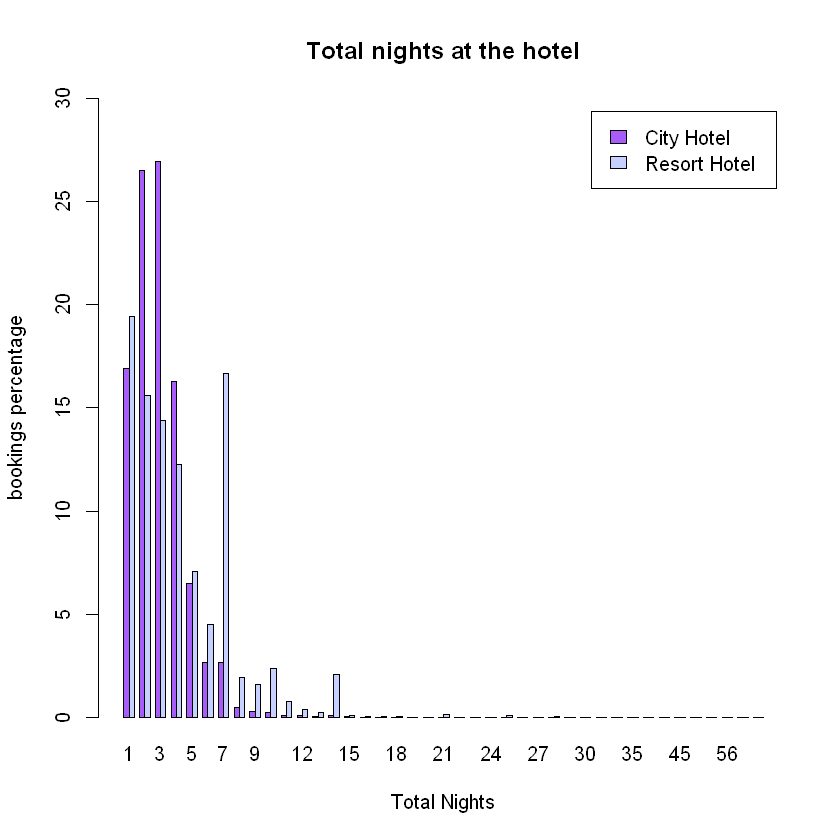

In [267]:
labels <- c("City Hotel", "Resort Hotel")


total_nights = data$stays_in_weekend_nights + data$stays_in_week_nights
hotel_nights = prop.table(table(total_nights, data$hotel), margin=2)*100
hotel_nights = t(hotel_nights)

barplot(hotel_nights, beside = T, ylim = c(0,30), main = "Total nights at the hotel",
        xlab = 'Total Nights', ylab = 'bookings percentage', legend.text = labels, col = colors)